In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import tensorflow as tf


In [ ]:
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [ ]:
file_path = '/content/drive/MyDrive/Files and Data/gender and channels csv/binary_labels_5-4FeatureNorm.csv'
features=np.load('/content/drive/MyDrive/Colab Notebooks/DL models/BiLSTM/wavelet_feature_lstm_5_4.npy') # choose the feature numpy file
#features =np.concatenate((features, features1), axis=1)
rows=features.shape[0]
cols=features.shape[1]
# for  calculation of  number of trails  for traning and testing
percent_train=np.floor(0.75*rows)  # 75 % for testing
percent_test=np.ceil(0.25*rows)   # 25 % for traninig
print(f'row:{rows} cols:{cols} trains:{percent_train} test:{percent_test} ')


row:33280 cols:5 trains:24960.0 test:8320.0 


In [ ]:
# Load the CSV file into a DataFrame
labels_gender = pd.read_csv(file_path)
# print(labels_gender.head)
# Assuming 'wavelet_features' is a NumPy array and 'labels' is a DataFrame with two columns 'Class' and 'Gender'
# Split the data into males and females
males = labels_gender[labels_gender['Gender'] == 'Male']
females = labels_gender[labels_gender['Gender'] == 'Female']

# Split males and females into training and test sets and ensure equal no. of training sets between females and males.
#no. of trials=40trial*32subject*26 OSW=33280 total trials==>1040 trail/subject==>12480training males (12 males) and 5200testing males (5 males)
males_train, males_test = train_test_split(males.index, test_size=5200, random_state=42)

#no. of trials=40trial*32subject*26 OSW=33280 total trials==>1040 trail/subject==>12480training males (12 females) and 3120 testing males (3 females)
females_train, females_test = train_test_split(females.index, test_size=3120, random_state=42)


# Combine the training sets for both genders
train_indices = np.concatenate([males_train, females_train])

# Create the test set with 4160 males and 4160 females
test_indices = np.concatenate([males_test, females_test])

# Use the indices to select the corresponding data from the 'wavelet_features' NumPy array
train_data = features[train_indices, :]
test_data = features[test_indices, :]

# Extract the train and test labels from the DataFrame
train_labels = labels_gender.loc[train_indices]
test_labels = labels_gender.loc[test_indices]


In [ ]:
X_train=np.array(train_data)
# To drop a single column 'ColumnName'
train_labels = train_labels.drop('Gender', axis=1)
# we have labels for both arousal and val in train_labels
y_train=np.array(train_labels)
y_train_val=y_train[:,0]  # get val labes
y_train_arl=y_train[:,1]  # get arousal label

print(y_train_val.shape,y_train_arl.shape)
X_test=np.array(test_data)
test_labels=test_labels.drop('Gender',axis=1)
print(test_labels.head)
y_test=np.array(test_labels)
y_test_val=y_test[:,0]  # val test set
y_test_arl=y_test[:,1]  # arousal test set

# Assuming you have a DataFrame called 'labels_df' with the labels in a column named 'class_label'
class_counts_val = labels_gender['Binary Label val'].value_counts()
class_counts_arl= labels_gender['Binary Label arl'].value_counts()
print(class_counts_val)
print(class_counts_arl)
print(X_test.shape)

(24960,) (24960,)
<bound method NDFrame.head of        Binary Label val  Binary Label arl
16345                 0                 0
31125                 1                 1
12378                 0                 1
733                   0                 0
5445                  1                 1
...                 ...               ...
31820                 1                 0
1135                  1                 0
7416                  1                 1
31648                 1                 0
3651                  0                 0

[8320 rows x 2 columns]>
1    21008
0    12272
Name: Binary Label val, dtype: int64
1    21216
0    12064
Name: Binary Label arl, dtype: int64
(8320, 5, 378)


In [ ]:
print(X_train.shape,X_test.shape)
print(y_test_val.shape,y_test_arl.shape)
print(y_train_val.shape,y_train_arl.shape)
#%%
# Find unique classes
unique_classes = np.unique(y_train)
print(unique_classes)
# apply z score scaling to both train and test set
scaler= StandardScaler()
# X_train=scaler.fit_transform(X_train)
# X_test=scaler.fit_transform(X_test)



data_matrix_shape = X_train.shape
data_matrix_reshaped = X_train.reshape(-1, data_matrix_shape[-1])
data_matrix_normalized_2d = scaler.fit_transform(data_matrix_reshaped)
# Reshape the normalized data back to the original shape
X_train = data_matrix_normalized_2d.reshape(data_matrix_shape)

# for test set
data_matrix_shape = X_test.shape
data_matrix_reshaped = X_test.reshape(-1, data_matrix_shape[-1])

# Apply StandardScaler

data_matrix_normalized_2d = scaler.fit_transform(data_matrix_reshaped)

# Reshape the normalized data back to the original shape
X_test = data_matrix_normalized_2d.reshape(data_matrix_shape)

print(X_train.shape,X_test.shape)

#  for smote
X_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
print(X_reshaped.shape,y_train_val.shape)




# Apply SMOTE
smote = SMOTE()  # You can adjust parameters as needed
X_resampled, over_y = smote.fit_resample(X_reshaped,y_train_arl)
print(X_resampled.shape,over_y.shape)
# Reshape the resampled feature matrix back to 3D
over_X = X_resampled.reshape((X_resampled.shape[0], 5, 378))




# # apply smote  transform only on tranig data
# oversample = SMOTE()
# over_X, over_y = oversample.fit_resample(X_train,y_train_val)
print(over_X.shape,over_y.shape,X_train.shape,y_train_arl.shape)
unique_values, counts = np.unique(over_y, return_counts=True)
frequency_dict = dict(zip(unique_values, counts))

print("Frequency of each value:")
print(frequency_dict)

(24960, 5, 378) (8320, 5, 378)
(8320,) (8320,)
(24960,) (24960,)
[0 1]
(24960, 5, 378) (8320, 5, 378)
(24960, 1890) (24960,)
(31746, 1890) (31746,)
(31746, 5, 378) (31746,) (24960, 5, 378) (24960,)
Frequency of each value:
{0: 15873, 1: 15873}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Bidirectional, LSTM
from keras.optimizers import Adam

# Assuming the input shape is (5, 378)
input_shape = (5, 378)

# Define the model
model = Sequential()

# Adding First Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(1024, return_sequences=True), input_shape=(5, 378)))

# Adding Second Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(1024)))

# Add the fully connected layers
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

print(X_train.shape,y_train_arl.shape)

history = model.fit(over_X,
                    over_y,
                    epochs=50,
                    batch_size=512,
                    validation_split=0.15,
                    )


(24960, 5, 378) (24960,)
Epoch 1/50
53/53 [==============================] - 28s 215ms/step - loss: 0.6668 - accuracy: 0.5921 - val_loss: 0.7174 - val_accuracy: 0.5036
Epoch 2/50
53/53 [==============================] - 9s 176ms/step - loss: 0.6197 - accuracy: 0.6452 - val_loss: 0.6986 - val_accuracy: 0.5601
Epoch 3/50
53/53 [==============================] - 9s 178ms/step - loss: 0.5492 - accuracy: 0.7076 - val_loss: 0.4766 - val_accuracy: 0.8954
Epoch 4/50
53/53 [==============================] - 9s 178ms/step - loss: 0.4395 - accuracy: 0.7790 - val_loss: 0.2798 - val_accuracy: 0.9181
Epoch 5/50
53/53 [==============================] - 10s 183ms/step - loss: 0.3085 - accuracy: 0.8502 - val_loss: 0.3854 - val_accuracy: 0.7509
Epoch 6/50
53/53 [==============================] - 10s 187ms/step - loss: 0.2365 - accuracy: 0.8830 - val_loss: 0.2542 - val_accuracy: 0.8969
Epoch 7/50
53/53 [==============================] - 10s 188ms/step - loss: 0.1971 - accuracy: 0.9035 - val_loss: 0.2080 

Text(0, 0.5, 'Accuracy')

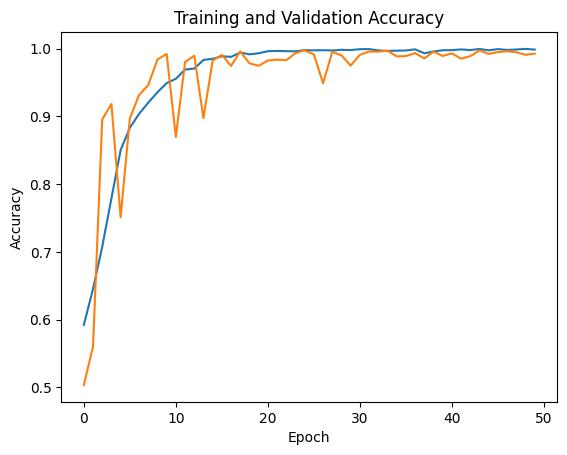

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
# Evaluate the model Classification Accuracy for Arousal Classification
accuracy = model.evaluate(X_test, y_test_arl)[1]
print('Accuracy:', accuracy)

260/260 [==============================] - 3s 13ms/step - loss: 0.2734 - accuracy: 0.9411
Accuracy: 0.9411057829856873


260/260 [==============================] - 5s 11ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2977
           1       0.96      0.95      0.95      5343

    accuracy                           0.94      8320
   macro avg       0.93      0.94      0.94      8320
weighted avg       0.94      0.94      0.94      8320

Precision: 0.9605
Recall: 0.9472
F1 Score: 0.9538


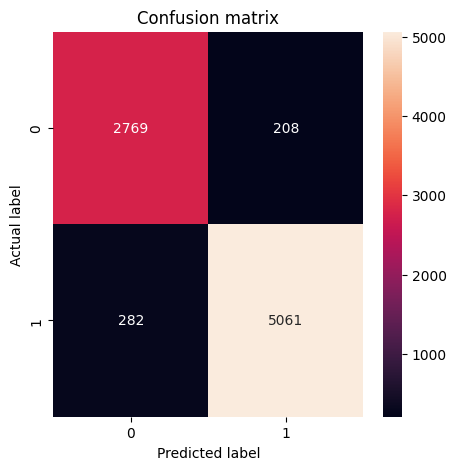

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
y_pred = model.predict(X_test)
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype("int32")
# print(y_pred)
conf_matrix = confusion_matrix(y_test_arl, y_pred_binary)
# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Print classification report
print("Classification Report:")
print(classification_report(y_test_arl, y_pred_binary))

# Calculate and print precision, recall, and F1 score
precision = precision_score(y_test_arl, y_pred_binary)
recall = recall_score(y_test_arl, y_pred_binary)
f1 = f1_score(y_test_arl, y_pred_binary)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")